In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [20]:
#Cargamos el dataframe de ventas de los tres años
df= pd.read_csv("../output/ModelDataset.csv")
df.sort_values(by='Date', inplace=True)
df_dummy = pd.get_dummies(df, columns=['Category', 'SubCategory','TipoTienda','DimensionesTienda','Ciudad'], drop_first=True)

In [ ]:
#Definicion de train-test split
fecha_corte = '2024-07-31'
train = df_dummy[df_dummy['mes_año'] <= fecha_corte]
test = df_dummy[df_dummy['mes_año'] > fecha_corte]

# Variable objetivo principal: cantidad
X_train = train.drop(columns=['Quantity','venta','Date'])
y_train = train['Quantity']

X_test = test.drop(columns=['Quantity','venta','Date'])
y_test = test['Quantity']

In [22]:
# MODELADO
# =================
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# SARIMAX a nivel global (cantidad total)
ts_total = df_dummy.groupby('mes_año')['Quantity'].sum().sort_index()
ts_train = ts_total[:fecha_corte]
ts_test = ts_total[fecha_corte:]
sarimax_model = SARIMAX(ts_train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_fit = sarimax_model.fit(disp=False)
pred_sarimax = sarimax_fit.predict(start=ts_test.index[0], end=ts_test.index[-1])

#PRONÓSTICO 3 MESES
# =====================
forecast_sarimax = sarimax_fit.get_forecast(steps=3)
forecast_ci = forecast_sarimax.conf_int()


c:\Users\Marlon\anaconda3\envs\prueba_tecnica\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Marlon\anaconda3\envs\prueba_tecnica\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Marlon\anaconda3\envs\prueba_tecnica\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Random Forest - MAPE: 0.4278, RMSE: 1.9277
Regresión Lineal - MAPE: 0.4844, RMSE: 1.8701
SARIMAX (total) - MAPE: 0.1088, RMSE: 6376725.3791


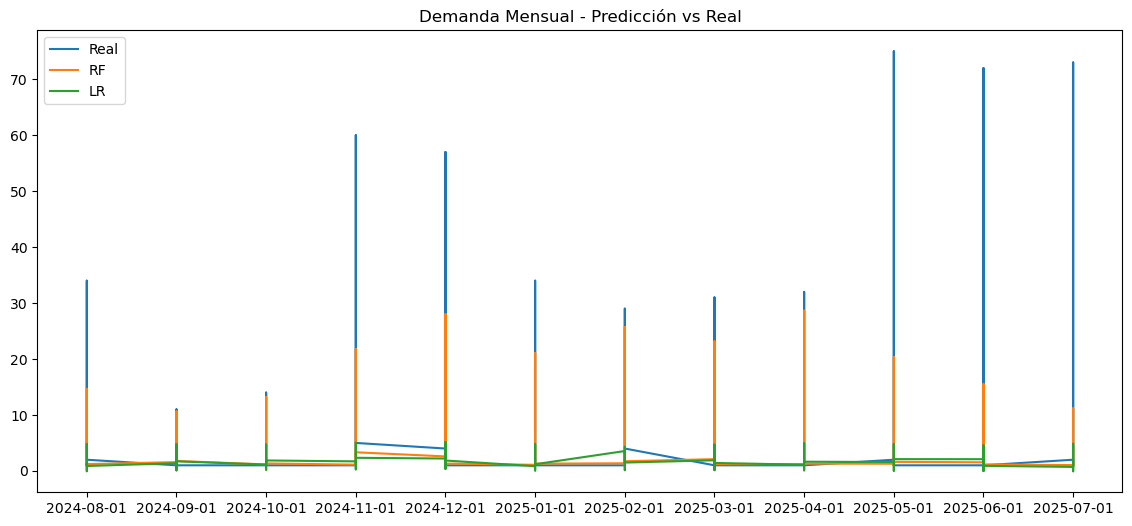

C:\Users\Marlon\AppData\Local\Temp\ipykernel_16884\1101474186.py:24: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(pred_sarimax.index, pred_sarimax.values, label='SARIMAX')


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x000001F93D757640>.

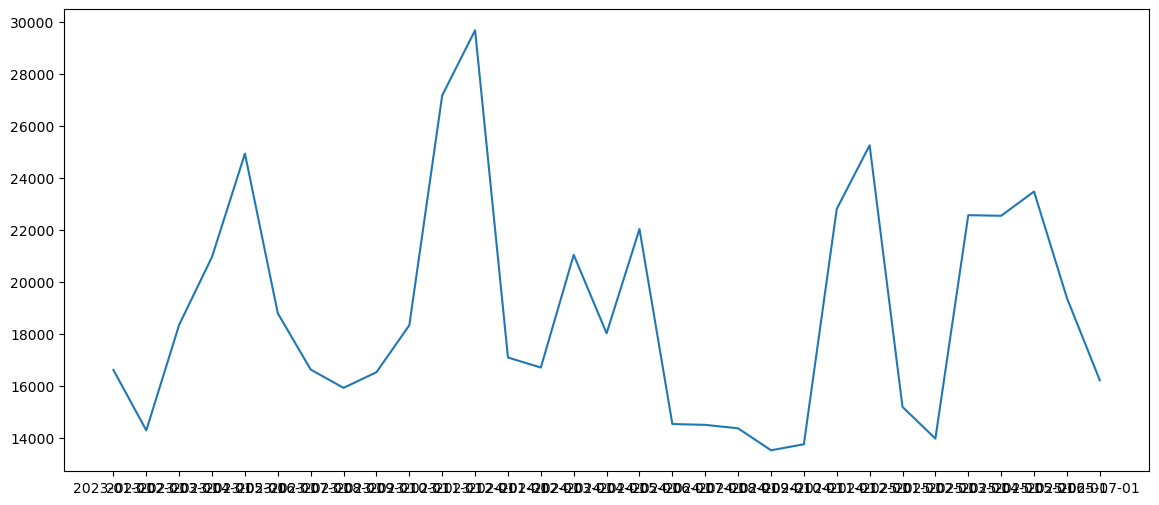

In [23]:
# 5) EVALUACIÓN
# =================
def eval_metrics(y_true, y_pred, modelo):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    print(f"{modelo} - MAPE: {mape:.4f}, RMSE: {rmse:.4f}")

eval_metrics(y_test, pred_rf, 'Random Forest')
eval_metrics(y_test, pred_lr, 'Regresión Lineal')
eval_metrics(ts_test, pred_sarimax, 'SARIMAX (total)')

# 7) VISUALIZACIÓN
# =================
plt.figure(figsize=(14,6))
plt.plot(test['mes_año'], y_test, label='Real')
plt.plot(test['mes_año'], pred_rf, label='RF')
plt.plot(test['mes_año'], pred_lr, label='LR')
plt.legend()
plt.title('Demanda Mensual - Predicción vs Real')
plt.show()

plt.figure(figsize=(14,6))
plt.plot(ts_total.index, ts_total.values, label='Histórico Total')
plt.plot(pred_sarimax.index, pred_sarimax.values, label='SARIMAX')
plt.plot(forecast_sarimax.predicted_mean.index, forecast_sarimax.predicted_mean.values, label='Pronóstico 3 Meses', linestyle='--')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Demanda Total Mensual - SARIMAX y Pronóstico')
plt.show()